# Note

This note will conduct an experiment following this pipeline:

1. Compose a Judge Committee, $C_J = \{f_1, \ldots, f_N\}$. Here, we can take two versions of Committee: SB type and B type. SB type Committee consists of specialized ResNet models while B type doesn't.

2. Here we define several terminologies:

- Let $D_{*} = (X_*, Y_*)$ denote dataset, where the asterisk reserves type of dataset, for instance $D_{\textrm{tr}}$. $D$ refers dataset (includes unseen data). 
- Define $I_C : D \to [0,1]$ which measures disagreement(or entropy) among Committee $C$. 
- $\alpha \in [0,1]$ denotes a given entropy threshold.
- For a dataset $D_{*}$, define $D^0_{*}(C) := \{I_C(x) < \alpha\}$ and $D^1_{*}(C) := \{I_C(x) \geq \alpha\}$.

3. Specialize each member of the Judge Committee $f \in C_J$ into $g$ on $D^1_{*}(C_J)$. We call the newly obtained Committee $C_S = \{g_1, \ldots, g_N\}$.

4. When an instance $x$ is given, first determine $I_{C_J}(x)$, and make prediction according to the value. If $I_{C_J}(x) < \alpha$ then $C_J$ predicts, otherwise $C_S$ does.

In [1]:
## load necessary libraries
import os, glob
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from keras.models import load_model
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Model
from scipy.stats import entropy
import math

## Compose Judge Committee

We can have two type of $C_J$: SB and B. 

In [2]:
## predefined dictionary for label
label_dict = {(3,1) : 'ResNet20v1',
        (3,2) : 'ResNet20v2',
        (9,1): 'ResNet56v1',
        (9,2): 'ResNet56v2'}

## load models

# Say 'B-type' model, where 'B' stands for 'Base'.
folder = 'CIFAR10models/ResNet/'
pattern = os.path.join(folder, '*cifar10*.keras')
file_list = sorted(glob.glob(pattern))
loaded_models= {os.path.basename(f): load_model(f) for f in file_list}

## Compose Committee
Judge_Committee_B = []
for file_name, model in loaded_models.items():
    # Extract model name from the file name
    base = file_name.replace('.keras','')
    parts = base.split('_')
    # base = n_3_v1_cifar10_1 or n_3_v1_cifar10
    # parts = [n, 3, v1, cifar10, 1] or [n, 3, v1, cifar10]
    model_name = label_dict[(int(parts[1]),int(parts[2][-1]))] + '_B_' +parts[-1][-1]
    Judge_Committee_B.append((model_name, model))
print(f"Total {len(Judge_Committee_B)} B-type models loaded")

# Say 'SB-type', where 'SB' stands for 'Specialized Base'.
folder = 'CIFAR10models/more_tunned/'
pattern = os.path.join(folder, '*_more_specialized*.keras')
file_list = sorted(glob.glob(pattern))
loaded_models.update({os.path.basename(f): load_model(f) for f in file_list})

## Compose Committee
Judge_Committee_SB = []
for file_name, model in loaded_models.items():
    # Extract model name from the file name
    base = file_name.replace('.keras','')
    parts = base.split('_')
    # base = ResNet20v1_more_specialized_0, ResNet20v1_once-more_specialized_0, or ResNet20v1_twice-more_specialized_0
    # parts = [ResNet20v1, more, specialized, 0] or [ResNet20v1, once-more, specialized, 0] and so forth.
    if parts[1] != 'more':
        continue
    model_name = parts[0] + '_SB_' + parts[-1]
    Judge_Committee_SB.append((model_name, model))
print(f"Total {len(Judge_Committee_SB)} SB-type models loaded")


Total 20 B-type models loaded
Total 20 SB-type models loaded


## Define $I$

We can have three measurements: 

- Let say $f_1(x) = \left(y^1_1, \ldots, y^m_1\right), \ldots, f_N(x) = \left(y^1_N, \ldots, y^m_N\right)$ with $m$-many classes and $N$-many models. 

- By taking $\arg\max f_i(x)$, we have each answers $a_1, \ldots , a_N$. $a_1, \ldots, a_N$ give discrete distribution such that $p_j = P(X=j) = \frac{\{a_i = j\}}{N}$ where $j=1,\ldots,m$. With this, we define $I^{\arg\max}_{C}(x) = -\sum p_i \log_{m}p_i$.

- With raw predictions, we define $\frac{\sum_{k=1}^N y^i_k}{N} = p_i$ and $I^\textrm{overall}_{C}(x) = -\sum p_i \log_{m}p_i$. Note that if $y^i_k = 0 $ or $1$ then it coincides with the previous one.

- Also with raw predictions, we define $ I^{\textrm{cross}} = -\sum_{k\neq l} \sum_{i = 1}^{m} y^i_k \log_m y^i_l $

In [3]:
from typing import Sequence


# Sequence allows to have anything that behaves like a sequence including lists, tuples, and arrays.
def cross_entropy(arrays: Sequence[np.ndarray], log_base: float | None = None) -> float:
    """
    Compute  f = - sum_{k != l} sum_{i=1}^m a_{i,k} * log( a_{i,l} )
    where each input is an array of shape (m, 1) (or (m,)).

    Parameters
    ----------
    arrays : sequence of np.ndarray
        N arrays, each of shape (m,1) or (m,). They should all have the same m.
    log_base : float or None, optional
        If provided (e.g., 10), compute logarithm in this base.
        If None, uses the natural logarithm.

    Returns
    -------
    float
        The scalar value of the cross entropy f among the arrays

    Notes
    -----
    - Time complexity is O(m N^2) dominated by the matrix multiply, where N is the length of arrays.
    """
    if len(arrays) == 0:
        return 0.0

    # Stack to shape (m, N)
    cols = [np.asarray(a).reshape(-1) for a in arrays]
    m = cols[0].shape[0]
    if any(c.shape[0] != m for c in cols):
        raise ValueError("All arrays must have the same first dimension m.")
    A = np.column_stack(cols)  # shape (m, N)

    L = np.log(A+1e-12)
    if log_base is not None:
        L = L / np.log(log_base)

    M = A.T @ L  # shape (N, N), M[k, l] = sum_i a_{i,k} * log(a_{i,l})
    total = -(np.sum(M) - np.trace(M))  # sum over k != l, then negate
    return float(total)

In [5]:
a1 = np.array([[0.2],[0.8]])
a2 = np.array([[0.5],[0.5]])
a3 = np.array([[0.9],[0.1]])

val = cross_entropy([a1, a2, a3], log_base=2) 
print('a1,a2,a3',val)

val = cross_entropy([a1, a1, a1],  log_base=2) 
print('a1,a1,a1',val)

val = cross_entropy([a2, a2, a2],  log_base=2) 
print('a2,a2,a2',val)

val = cross_entropy([a3, a3, a3], log_base=2) 
print('a3,a3,a3',val)

val = cross_entropy([a1, a2, a2],  log_base=2) 
print('a1,a2,a2',val)

val = cross_entropy([a3, a2, a2],  log_base=2) 
print('a3,a2,a2',val)

val = cross_entropy([a2, a3, a3],  log_base=2) 
print('a2,a3,a3',val)

val = cross_entropy([a1, a3, a3],  log_base=2) 
print('a1,a3,a3',val)

val = cross_entropy([a2, a1, a1],  log_base=2) 
print('a2,a1,a1',val)

val = cross_entropy([a3, a1, a1], log_base=2) 
print('a3,a1,a1',val)

a1,a2,a3 9.868764878503
a1,a1,a1 4.331568569306862
a2,a2,a2 5.999999999982688
a3,a3,a3 2.8139735615183747
a1,a2,a2 6.6438561897541675
a3,a2,a2 7.47393118830484
a2,a3,a3 6.411922375483403
a1,a3,a3 10.557733566108247
a2,a1,a1 6.087712379528892
a3,a1,a1 11.063598568704409


In [4]:
def get_entropy_array(committee : list[tuple[str,Model]],
                      entropy_version : str = "argmax",
                      num_classes : int = 10,
                      sample : np.ndarray = None, 
                      preds : dict[str, np.ndarray] = None) -> tuple[np.ndarray, dict[str, np.ndarray]]:
    '''
    param committee: list of tuple (member, model)
    param entropy_version: whether to use argmax, overall or cross_entropy version for entropy calculation
    param num_classes: number of targets
    param sample: numpy array of (n,) shape
    param preds: dictionary of (raw) predictions from each model in the committee.
    Either sample or preds must be provided. If both sample and preds are provided, preds will be used.
    
    return (numpy array of entropy of (n,) shape, dictionary of preds whose keys are the member names) 
    '''
    if sample is None and preds is None:
        raise ValueError("Either sample or preds must be provided")
    if entropy_version not in ["argmax", "overall", "cross_entropy"]:
        raise ValueError("entropy_version must be either 'argmax', 'overall' or 'cross_entropy'")

    if preds is None:
        preds = {}
        for member, model in committee:
            preds[member] = model.predict(sample,verbose = 0)
            
    if entropy_version == "argmax":
        stacked = np.stack([np.argmax(member_pred, axis=-1) for member_pred in preds.values()], axis=1)
        counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=num_classes), axis=1, arr=stacked)
        probs = counts / counts.sum(axis=1, keepdims=True)
        disagreements = entropy(probs, axis=1, base = num_classes)
        ## if member prediction is of (*,) dimensional array, then error will occur at stacked and counting procedure as well.
        ## To remedy this, we can put reshaping line of code before stacking.
        
    elif entropy_version == "overall": # overall
        stacked = np.stack([member_pred for member_pred in preds.values()], axis=1)
        probs = np.sum(stacked,axis=1)/len(committee)
        disagreements = entropy(probs, axis=1, base = num_classes)
    elif entropy_version == 'cross_entropy':
        stacked = np.stack([member_pred for member_pred in preds.values()], axis=1)
        
        n = len(stacked)
        
        disagreements = np.zeros(n)
        for i in range(n):
            disagreements[i] = cross_entropy(stacked[i,:], log_base=num_classes)
        
    return (disagreements, preds) 

## Define entropy threshold

We may define entropy threhold arbitrarily. Or, we can see the boxplots of entropy.

In [5]:
import matplotlib.pyplot as plt

def plot_disagreements(disagreements: np.ndarray | dict[str, np.ndarray], title: str = "Disagreements"):
    '''
    disagreements is either a numpy array of entropies, or a dictionary of entropy whose keys are the name of sample.
    '''
    plt.figure(figsize=(16, 6))
    plt.boxplot(disagreements if isinstance(disagreements, np.ndarray) else list(disagreements.values()))
    plt.title(title)
    if isinstance(disagreements, dict):
        plt.xticks(ticks=range(1, len(disagreements) + 1), labels=list(disagreements.keys()))
    else:
        plt.xlabel("Sample Index")
    plt.ylabel("Disagreement")
    plt.show()
    
def get_statistics(disagreements: np.ndarray) -> dict[str, float]:
    '''
    disagreements is a numpy array of entropies.
    return dictionary of average, median, std, 1Q, 3Q.
    '''
    return {
        "average": float(np.mean(disagreements)),
        "median": float(np.median(disagreements)),
        "std": float(np.std(disagreements)),
        "1Q": float(np.percentile(disagreements, 25)),
        "3Q": float(np.percentile(disagreements, 75)),
    }

## Choose alpha here

In [8]:
alpha = 0.4

## Specialization function

In [6]:
from keras import layers
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 5, 10, 15, 18 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 18:
        lr *= 0.5e-3
    elif epoch > 15:
        lr *= 1e-3
    elif epoch > 10:
        lr *= 1e-2
    elif epoch > 5:
        lr *= 1e-1
#     print('Learning rate: ', lr)
    return lr

def turn_specialist(model : Model, path : str,
        x_tr: np.ndarray | None = None,
        y_tr: np.ndarray | None = None,
        x_v: np.ndarray | None = None,
        y_v: np.ndarray | None = None,
        num_classes : int = 10,
        epochs: int = 21,
        learning_rate : float = 1e-3,
        batch_size: int = 128,
        # save_each: bool = False,
        # save_bests: int | None = None,
        verbose: int = 1,
        name : str = '',
        add_last_dense : bool = True
    ):
        if add_last_dense:
            # build specialist network
            base = Model(inputs = model.inputs, outputs = model.layers[-2].output, name=f"base{name}")
            x    = keras.Input(shape=base.input_shape[1:], name=f"in{name}")
            y    = Dense(num_classes, name=f"dense{name}")(base(x)) 
            z    = layers.Softmax(name=f"softmax{name}")(y)
            specialist = Model(inputs = x, outputs = z)
            specialist.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="categorical_crossentropy",
                metrics=["accuracy"],
            )
        else:
            # we don't add a new dense layer
            # and fine tune it.
            specialist = model
            specialist.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="categorical_crossentropy",
                metrics=["accuracy"],
            )


        # callbacks
        callbacks = [ModelCheckpoint(path, monitor="val_accuracy",
                                    save_best_only=True, verbose=verbose)]
        
        callbacks += [LearningRateScheduler(lr_schedule),
                        ReduceLROnPlateau(factor=np.sqrt(0.1), patience=5, min_lr=5e-7)]

        # fit 
        hist = specialist.fit(x_tr, y_tr, batch_size=batch_size,
                        validation_data=(x_v, y_v),
                        epochs=epochs, callbacks=callbacks, verbose=verbose)



        # ---------- summary ----------
        metric = "val_accuracy"
        best = np.max(hist.history[metric])
        first = hist.history[metric][0]
        print(f"best {metric} {best:.3f} (first {first:.3f})")
        return specialist, hist


In [7]:
def specialize_Committee(committee: dict[str, Model], 
                         training_data: tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
                         path : str,
                         data_name: str = '',
                         committee_name:str = '',
                         num_classes : int = 10):
    x_tr, y_tr, x_v, y_v = training_data
    if y_tr.ndim == 1:
        y_tr = to_categorical(y_tr, num_classes)
    if y_v.ndim == 1:
        y_v = to_categorical(y_v, num_classes)
    for member, model in committee:
        print(f"Training specialist for {member}...")
        # baseline, which is specialize once with the original labels.
        specialist, history = turn_specialist(model,
                        path=f'./specialists/{committee_name}/{member}_{data_name}.keras',
                        x_tr = x_tr,
                        y_tr = y_tr,
                        x_v = x_v,
                        y_v = y_v,
                        name = f'{committee_name}_{member}_{data_name}',
                        verbose = 0
                        )
        # see the graph of training process
        plt.plot(history.history['accuracy'], label='train accuracy')
        plt.plot(history.history['val_accuracy'], label='val accuracy')
        plt.title(f'Accuracy of {member}\non {data_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # save the specialist model
        specialist.save(path +f'{committee_name}/{member}_{data_name}.keras')
    

## Load datasets

In [8]:
## load CIFAR10 dataset

(x, y), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                              random_state=42) # random state has been always 42.
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train_categorical_10 = to_categorical(y_train,10)
y_val_categorical_10 = to_categorical(y_val,10)
y_test_categorical_10 = to_categorical(y_test,10)

## we load only two adversarial samples

import re

pattern = re.compile(r'_\d+to\d+_')

folder = './adversarial_examples/gen_by_ResNet'
all_files = os.listdir(folder)

filtered_files = [
    fname for fname in all_files
    if fname.endswith('.npy') and not pattern.search(fname)]


## load all the training and validation dataset

adv_dataset = {}
import re
for f in filtered_files:
    
    base = f.replace('.keras.npy','').replace('.npy','')
    parts = base.split('_')
    '''
    cwl2_x_tr_untargeted
    cwl2_x_v_untargeted
    cwl2_x_test_untargeted <- gen by ResNet56v1_0
    cwl2_x_test_untargeted_gen_by_ResNet56v1_1
    pgd_0.376_x_untarget
    pgd_0.376_x_val_untarget
    pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10
    '''
    if base in ['cwl2_x_tr_untargeted', 
                'cwl2_x_v_untargeted',
                 'cwl2_x_test_untargeted', 
                #  'cwl2_x_test_untargeted_gen_by_ResNet56v1_1',
                 'pgd_0.376_x_untarget', 
                 'pgd_0.376_x_val_untarget',
                 'pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10']:
        attack_type = parts[0]
        if attack_type == 'cwl2':
            if parts[2] == 'tr':
                train_or_val_or_test = 'train'
            elif parts[2] == 'test':
                train_or_val_or_test = 'test'
            else:
                train_or_val_or_test = 'val'
        else:
            attack_type = 'PGD'
            if parts[3] == 'val':
                train_or_val_or_test = 'val'
            elif parts[3] == 'test':
                train_or_val_or_test = 'test'
            else:
                train_or_val_or_test = 'train'
    else:
        continue
    key = (attack_type, train_or_val_or_test)
    adv_dataset[key] = np.load(os.path.join(folder, f))
    

adv_dataset[('VGG','test')] = np.load('./adversarial_examples/gen_by_VGG/pgd_0.376_x_test_untarget_by_vgg19.npy')
print('-'*50, 'keys for adv samples', '-'*50)
for k in adv_dataset.keys():
    print(k)
    
    

-------------------------------------------------- keys for adv samples --------------------------------------------------
('cwl2', 'val')
('cwl2', 'train')
('PGD', 'val')
('PGD', 'train')
('PGD', 'test')
('cwl2', 'test')
('VGG', 'test')


## Get raw predictions

In [14]:
raw_predictions_B = {
    'original': {'train':{}, 'val':{}, 'test':{}},
    'cwl2': {'train':{}, 'val':{}, 'test':{}},
    'PGD': {'train':{}, 'val':{}, 'test':{}},
    'VGG': {'test':{}}
    }


for member, model in Judge_Committee_B:
    raw_predictions_B['original']['train'][member] = model.predict(x_train, verbose=0)
    raw_predictions_B['original']['val'][member] = model.predict(x_val, verbose=0)
    raw_predictions_B['original']['test'][member] = model.predict(x_test, verbose=0)

    for key, adv_samples in adv_dataset.items():
        raw_predictions_B[key[0]][key[1]][member] = model.predict(adv_samples, verbose=0)
        

import pickle as pkl

## dump raw predictions into pickle files
with open('./data/raw_predictions_B.pkl', 'wb') as f:
    pkl.dump(raw_predictions_B, f)
    
raw_predictions_SB = {
    'original': {'train':{}, 'val':{}, 'test':{}},
    'cwl2': {'train':{}, 'val':{}, 'test':{}},
    'PGD': {'train':{}, 'val':{}, 'test':{}},
    'VGG': {'test':{}}
    }


for member, model in Judge_Committee_SB:
    raw_predictions_SB['original']['train'][member] = model.predict(x_train, verbose=0)
    raw_predictions_SB['original']['val'][member] = model.predict(x_val, verbose=0)
    raw_predictions_SB['original']['test'][member] = model.predict(x_test, verbose=0)

    for key, adv_samples in adv_dataset.items():
        raw_predictions_SB[key[0]][key[1]][member] = model.predict(adv_samples, verbose=0)
        

## dump raw predictions into pickle files
with open('./data/raw_predictions_SB.pkl', 'wb') as f:
    pkl.dump(raw_predictions_SB, f)

## get entropies

In [52]:
# ## Load raw predictions_SB from pickle files
# with open('./data/raw_predictions_SB.pkl', 'rb') as f:
#     raw_predictions_SB = pkl.load(f)
# ## Load raw predictions_B from pickle files
# with open('./data/raw_predictions_B.pkl', 'rb') as f:
#     raw_predictions_B = pkl.load(f)

entropy_arrays_SB = {}
for data_name in raw_predictions_SB.keys():
    for data_type in raw_predictions_SB[data_name].keys():
        entropy_array = get_entropy_array(Judge_Committee_SB, 
                          entropy_version = 'cross_entropy',
                          preds = raw_predictions_SB[data_name][data_type])
        entropy_arrays_SB[(data_name, data_type)] = entropy_array[0]

## dump it
with open('./data/entropy_arrays_SB.pkl', 'wb') as f:
    pkl.dump(entropy_arrays_SB, f)
    
entropy_arrays_B = {}
for data_name in raw_predictions_B.keys():
    for data_type in raw_predictions_SB[data_name].keys():
        entropy_array = get_entropy_array(Judge_Committee_B, 
                          entropy_version = 'cross_entropy',
                          preds = raw_predictions_B[data_name][data_type])
        entropy_arrays_B[(data_name, data_type)] = entropy_array[0]

## dump it
with open('./data/entropy_arrays_B.pkl', 'wb') as f:
    pkl.dump(entropy_arrays_B, f)

## See statistics

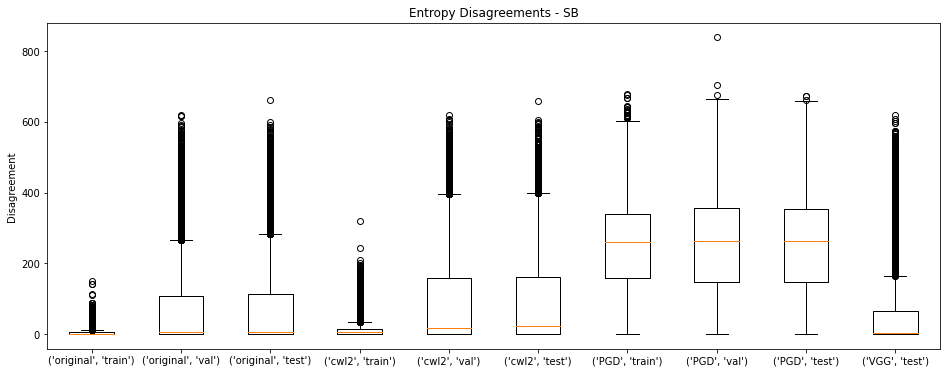

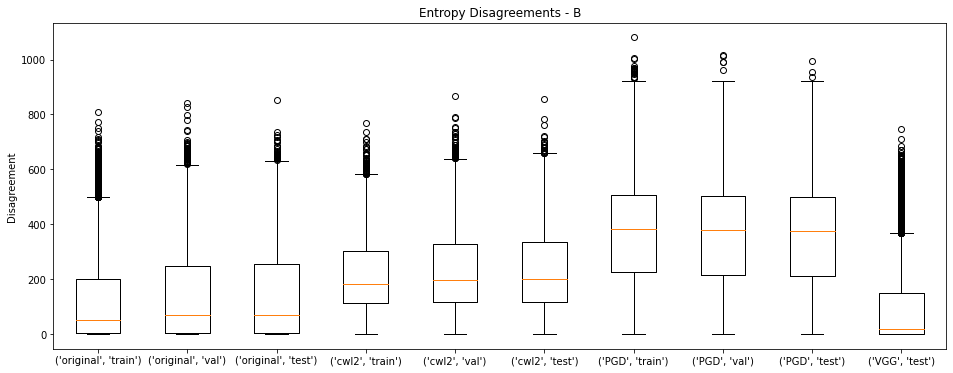

,Comm,Data,type,average,median,std,1Q,3Q
0,SB,original,train,3.558099,1.154288,6.137827,0.139385,4.511124
1,SB,original,val,76.728319,4.689221,125.704838,0.171311,106.102402
2,SB,original,test,78.615350,5.506968,125.825234,0.178620,113.342524
3,SB,cwl2,train,11.455466,4.340193,19.222501,0.663013,14.479957
4,SB,cwl2,val,95.299408,18.138812,133.167473,0.856957,158.557018
5,SB,cwl2,test,96.696613,22.299719,132.413606,0.913926,159.828545
6,SB,PGD,train,249.890704,259.218994,125.722927,158.819229,339.175972
7,SB,PGD,val,254.468250,263.551483,139.923229,148.314407,356.356071
8,SB,PGD,test,253.035669,262.866684,138.139281,148.356571,352.802559
9,SB,VGG,test,65.354817,1.368175,120.030005,0.063649,66.194923


In [65]:
# ## Load entropy arrays from pickle files
# with open('./data/entropy_arrays_SB.pkl', 'rb') as f:
#     entropy_arrays_SB = pkl.load(f)
# with open('./data/entropy_arrays_B.pkl', 'rb') as f:
#     entropy_arrays_B = pkl.load(f)

plot_disagreements(entropy_arrays_SB, title = "Entropy Disagreements - SB")

plot_disagreements(entropy_arrays_B, title = "Entropy Disagreements - B")

# Collect statistics for SB
sb_stats = []
for key, value in entropy_arrays_SB.items():
    stats = get_statistics(value)
    stats_row = {'Comm': 'SB', 'Data': key[0], 'type': key[1], **stats}
    sb_stats.append(stats_row)

# Collect statistics for B
b_stats = []
for key, value in entropy_arrays_B.items():
    stats = get_statistics(value)
    stats_row = {'Comm': 'B', 'Data': key[0], 'type': key[1], **stats}
    b_stats.append(stats_row)

# Combine and create DataFrame
all_stats = sb_stats + b_stats
df_stats = pd.DataFrame(all_stats)
df_stats

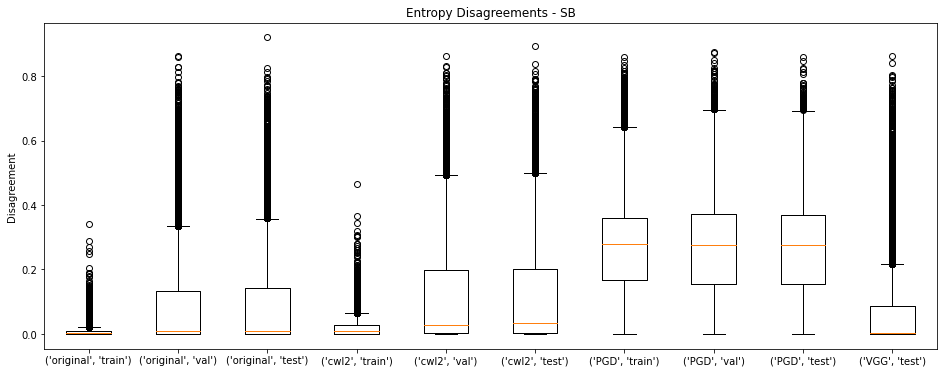

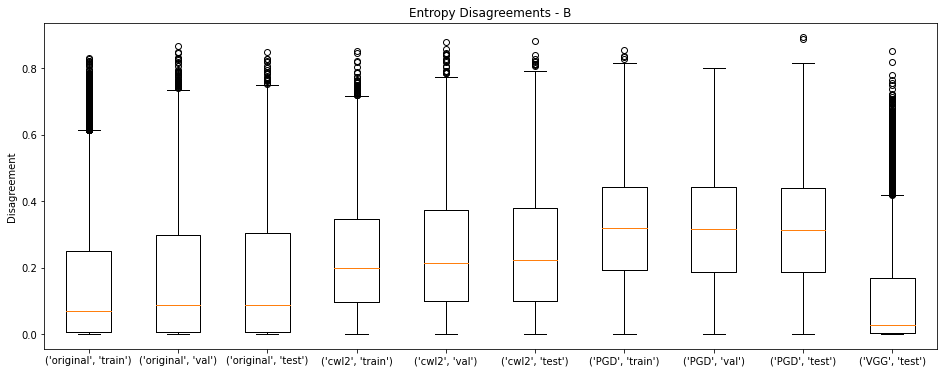

,Comm,Data,type,average,median,std,1Q,3Q
0,SB,original,train,0.007259,0.002291,0.012783,0.000290,0.009053
1,SB,original,val,0.096748,0.008151,0.157537,0.000348,0.134417
2,SB,original,test,0.099928,0.009540,0.158950,0.000361,0.143458
3,SB,cwl2,train,0.020269,0.008234,0.031226,0.001308,0.026741
4,SB,cwl2,val,0.120105,0.028398,0.166878,0.001652,0.197979
5,SB,cwl2,test,0.122562,0.033785,0.167141,0.001743,0.200818
6,SB,PGD,train,0.274109,0.280119,0.146742,0.168437,0.358261
7,SB,PGD,val,0.275653,0.277039,0.161402,0.154222,0.371078
8,SB,PGD,test,0.274388,0.276205,0.158897,0.154701,0.370003
9,SB,VGG,test,0.079618,0.002494,0.145546,0.000130,0.086776


In [66]:
# ## Load raw predictions_SB from pickle files
# with open('./data/raw_predictions_SB.pkl', 'rb') as f:
#     raw_predictions_SB = pkl.load(f)
# ## Load raw predictions_B from pickle files
# with open('./data/raw_predictions_B.pkl', 'rb') as f:
#     raw_predictions_B = pkl.load(f)

entropy_arrays_SB = {}
for data_name in raw_predictions_SB.keys():
    for data_type in raw_predictions_SB[data_name].keys():
        entropy_array = get_entropy_array(Judge_Committee_SB, 
                          entropy_version = 'overall',
                          preds = raw_predictions_SB[data_name][data_type])
        entropy_arrays_SB[(data_name, data_type)] = entropy_array[0]

# ## dump it
# with open('./data/entropy_arrays_SB.pkl', 'wb') as f:
#     pkl.dump(entropy_arrays_SB, f)
    
entropy_arrays_B = {}
for data_name in raw_predictions_B.keys():
    for data_type in raw_predictions_SB[data_name].keys():
        entropy_array = get_entropy_array(Judge_Committee_B, 
                          entropy_version = 'overall',
                          preds = raw_predictions_B[data_name][data_type])
        entropy_arrays_B[(data_name, data_type)] = entropy_array[0]

# ## dump it
# with open('./data/entropy_arrays_B.pkl', 'wb') as f:
#     pkl.dump(entropy_arrays_B, f)

# ## Load entropy arrays from pickle files
# with open('./data/entropy_arrays_SB.pkl', 'rb') as f:
#     entropy_arrays_SB = pkl.load(f)
# with open('./data/entropy_arrays_B.pkl', 'rb') as f:
#     entropy_arrays_B = pkl.load(f)

plot_disagreements(entropy_arrays_SB, title = "Entropy Disagreements - SB")

plot_disagreements(entropy_arrays_B, title = "Entropy Disagreements - B")

# Collect statistics for SB
sb_stats = []
for key, value in entropy_arrays_SB.items():
    stats = get_statistics(value)
    stats_row = {'Comm': 'SB', 'Data': key[0], 'type': key[1], **stats}
    sb_stats.append(stats_row)

# Collect statistics for B
b_stats = []
for key, value in entropy_arrays_B.items():
    stats = get_statistics(value)
    stats_row = {'Comm': 'B', 'Data': key[0], 'type': key[1], **stats}
    b_stats.append(stats_row)

# Combine and create DataFrame
all_stats = sb_stats + b_stats
df_stats = pd.DataFrame(all_stats)
df_stats

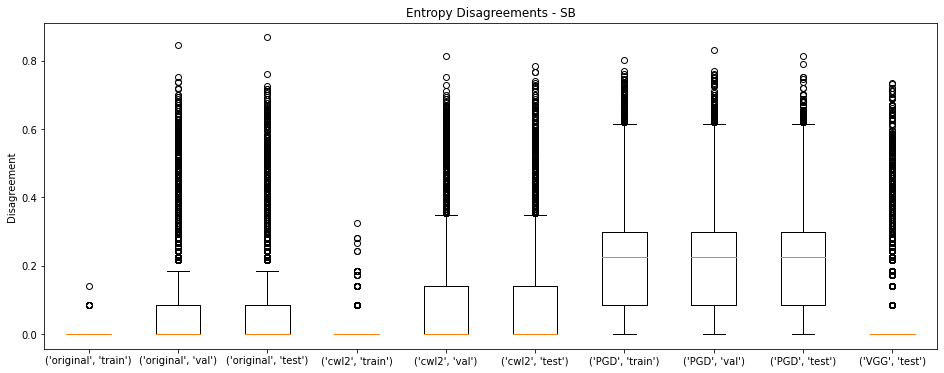

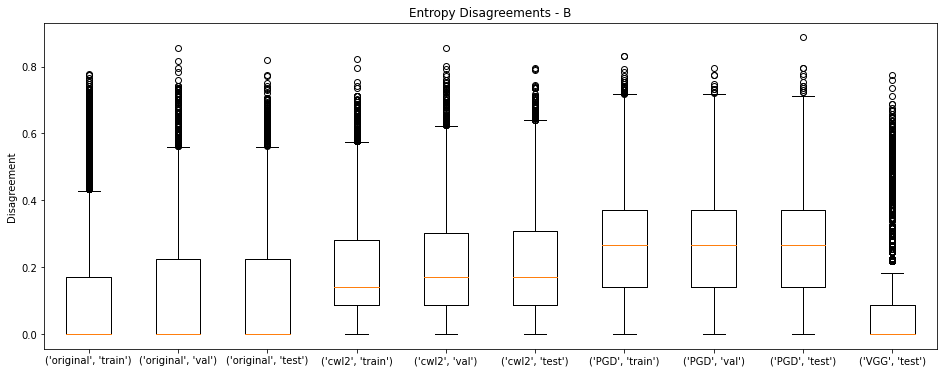

,Comm,Data,type,average,median,std,1Q,3Q
0,SB,original,train,0.000021,0.000000,0.001409,0.000000,0.000000
1,SB,original,val,0.068148,0.000000,0.132090,0.000000,0.086214
2,SB,original,test,0.070625,0.000000,0.134005,0.000000,0.086214
3,SB,cwl2,train,0.002008,0.000000,0.015350,0.000000,0.000000
4,SB,cwl2,val,0.085606,0.000000,0.142582,0.000000,0.141182
5,SB,cwl2,test,0.087003,0.000000,0.142399,0.000000,0.141182
6,SB,PGD,train,0.221799,0.225045,0.134401,0.086214,0.298855
7,SB,PGD,val,0.223864,0.225045,0.148521,0.086214,0.298855
8,SB,PGD,test,0.222988,0.225045,0.145966,0.086214,0.298855
9,SB,VGG,test,0.058008,0.000000,0.122491,0.000000,0.000000


In [67]:
# ## Load raw predictions_SB from pickle files
# with open('./data/raw_predictions_SB.pkl', 'rb') as f:
#     raw_predictions_SB = pkl.load(f)
# ## Load raw predictions_B from pickle files
# with open('./data/raw_predictions_B.pkl', 'rb') as f:
#     raw_predictions_B = pkl.load(f)

entropy_arrays_SB = {}
for data_name in raw_predictions_SB.keys():
    for data_type in raw_predictions_SB[data_name].keys():
        entropy_array = get_entropy_array(Judge_Committee_SB, 
                          entropy_version = 'argmax',
                          preds = raw_predictions_SB[data_name][data_type])
        entropy_arrays_SB[(data_name, data_type)] = entropy_array[0]

# ## dump it
# with open('./data/entropy_arrays_SB.pkl', 'wb') as f:
#     pkl.dump(entropy_arrays_SB, f)
    
entropy_arrays_B = {}
for data_name in raw_predictions_B.keys():
    for data_type in raw_predictions_SB[data_name].keys():
        entropy_array = get_entropy_array(Judge_Committee_B, 
                          entropy_version = 'argmax',
                          preds = raw_predictions_B[data_name][data_type])
        entropy_arrays_B[(data_name, data_type)] = entropy_array[0]

# ## dump it
# with open('./data/entropy_arrays_B.pkl', 'wb') as f:
#     pkl.dump(entropy_arrays_B, f)

# ## Load entropy arrays from pickle files
# with open('./data/entropy_arrays_SB.pkl', 'rb') as f:
#     entropy_arrays_SB = pkl.load(f)
# with open('./data/entropy_arrays_B.pkl', 'rb') as f:
#     entropy_arrays_B = pkl.load(f)

plot_disagreements(entropy_arrays_SB, title = "Entropy Disagreements - SB")

plot_disagreements(entropy_arrays_B, title = "Entropy Disagreements - B")

# Collect statistics for SB
sb_stats = []
for key, value in entropy_arrays_SB.items():
    stats = get_statistics(value)
    stats_row = {'Comm': 'SB', 'Data': key[0], 'type': key[1], **stats}
    sb_stats.append(stats_row)

# Collect statistics for B
b_stats = []
for key, value in entropy_arrays_B.items():
    stats = get_statistics(value)
    stats_row = {'Comm': 'B', 'Data': key[0], 'type': key[1], **stats}
    b_stats.append(stats_row)

# Combine and create DataFrame
all_stats = sb_stats + b_stats
df_stats = pd.DataFrame(all_stats)
df_stats

## Choose entropy threshold

In [68]:
## With JudgeCommittee_SB, based on the plot: average threshold

## Load entropy arrays from pickle files
with open('./data/entropy_arrays_SB.pkl', 'rb') as f:
    entropy_arrays_SB = pkl.load(f)
with open('./data/entropy_arrays_B.pkl', 'rb') as f:
    entropy_arrays_B = pkl.load(f)

for key, value in entropy_arrays_SB.items():
    print(key)
    
        
    stats = get_statistics(value)
    alpha = stats['average']
    print(alpha)
    loc_0 = entropy_arrays_SB[key]<alpha
    loc_1 = entropy_arrays_SB[key]>=alpha
    X_0 = raw_predictions_SB[key[0]][key[1]][loc_0]
    X_1 = raw_predictions_SB[key[0]][key[1]][loc_1]
    
    
# for key, value in entropy_arrays_B.items():
#     print(f"{key}: {get_statistics(value)}")

('original', 'train')
('original', 'val')
('original', 'test')
('cwl2', 'train')
('cwl2', 'val')
('cwl2', 'test')
('PGD', 'train')
('PGD', 'val')
('PGD', 'test')
('VGG', 'test')


## Accuracies on each X_0 and X_1

In [92]:
## With JudgeCommittee_SB, based on the plot: average threshold
## samples are PGD untargeted.
tables = []
for member, model in Judge_Committee_SB:
    row = {"Member": member}
    for key, value in entropy_arrays_SB.items():

        if key[1] == 'train':
            truth = y_train.reshape(-1)
        elif key[1] == 'val':
            truth = y_val.reshape(-1)
        else:
            truth = y_test.reshape(-1)
        stats = get_statistics(value)
        alpha = stats['average']
        loc_0 = entropy_arrays_SB[key]<alpha
        loc_1 = entropy_arrays_SB[key]>=alpha
        n = len(loc_0)
    
    
    
        X_0 = raw_predictions_SB[key[0]][key[1]][member][:n][loc_0]
        X_1 = raw_predictions_SB[key[0]][key[1]][member][:n][loc_1]
        acc = np.sum(np.argmax(raw_predictions_SB[key[0]][key[1]][member][:n],axis=-1) == truth[:n]) /len(raw_predictions_SB[key[0]][key[1]][member][:n])
        acc_0 = np.sum((np.argmax(X_0[:n],axis=-1) == truth[:n][loc_0]))/len(X_0[:n])
        acc_1 = np.sum((np.argmax(X_1[:n],axis=-1) == truth[:n][loc_1]))/len(X_1[:n])
    

        row[f"{key}_all"] = np.round(acc, 4)
        row[f"{key}_0"] = np.round(acc_0, 4)
        row[f"{key}_1"] = np.round(acc_1, 4)
    tables.append(row)
table = pd.DataFrame(tables)


In [124]:
sample = 'PGD'

In [125]:
table[table.columns[table.columns.str.startswith(f"('{sample}")]]

,"('PGD', 'train')_all","('PGD', 'train')_0","('PGD', 'train')_1","('PGD', 'val')_all","('PGD', 'val')_0","('PGD', 'val')_1","('PGD', 'test')_all","('PGD', 'test')_0","('PGD', 'test')_1"
0,0.5974,0.6296,0.5685,0.5216,0.5510,0.4949,0.5179,0.5359,0.5016
1,0.5432,0.6059,0.4870,0.4795,0.5236,0.4394,0.4738,0.5192,0.4326
2,0.5658,0.6175,0.5196,0.5011,0.5407,0.4652,0.4860,0.5239,0.4517
3,0.5641,0.6115,0.5216,0.4939,0.5299,0.4612,0.4906,0.5281,0.4566
4,0.5284,0.5974,0.4667,0.4727,0.5234,0.4266,0.4566,0.5125,0.4059
5,0.5383,0.6046,0.4790,0.4751,0.5220,0.4326,0.4724,0.5127,0.4358
6,0.6073,0.6367,0.5810,0.5256,0.5436,0.5093,0.5251,0.5434,0.5085
7,0.5317,0.5994,0.4712,0.4669,0.5266,0.4127,0.4618,0.5127,0.4156
8,0.5998,0.6293,0.5735,0.5575,0.5573,0.5577,0.5344,0.5449,0.5249
9,0.6292,0.6409,0.6188,0.5487,0.5482,0.5491,0.5509,0.5457,0.5556


In [117]:
adv_dataset.keys()

dict_keys([('cwl2', 'val'), ('cwl2', 'train'), ('PGD', 'val'), ('PGD', 'train'), ('PGD', 'test'), ('cwl2', 'test'), ('VGG', 'test')])

## Specialize C_J into C_s

Training specialist for ResNet20v1_SB_0...
best val_accuracy 0.858 (first 0.728)


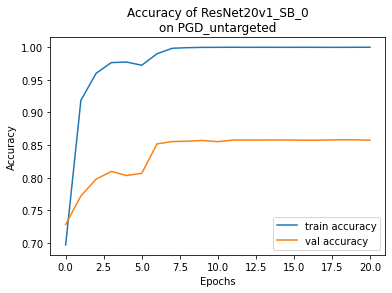

Training specialist for ResNet20v1_SB_1...
best val_accuracy 0.855 (first 0.707)


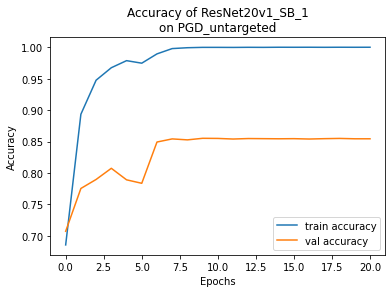

Training specialist for ResNet20v1_SB_2...
best val_accuracy 0.862 (first 0.738)


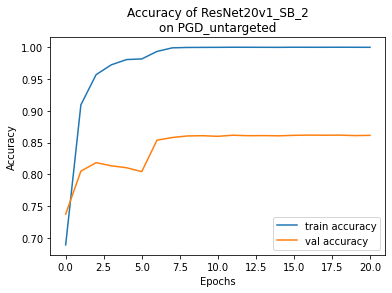

Training specialist for ResNet20v1_SB_3...
best val_accuracy 0.854 (first 0.722)


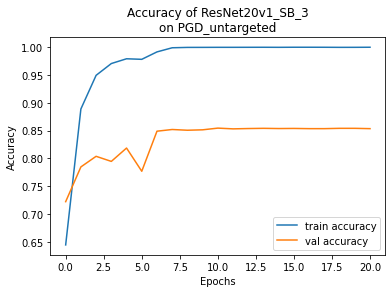

Training specialist for ResNet20v1_SB_4...
best val_accuracy 0.849 (first 0.744)


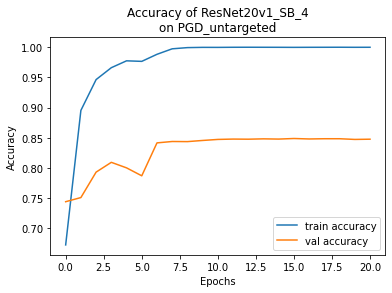

Training specialist for ResNet20v1_SB_5...
best val_accuracy 0.852 (first 0.704)


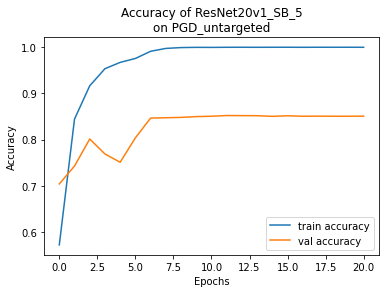

Training specialist for ResNet20v1_SB_6...
best val_accuracy 0.850 (first 0.732)


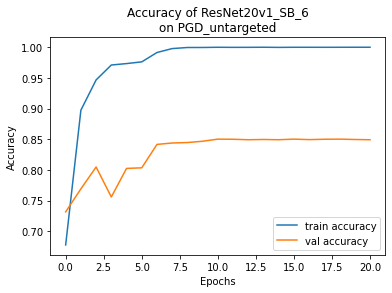

Training specialist for ResNet20v1_SB_7...
best val_accuracy 0.847 (first 0.769)


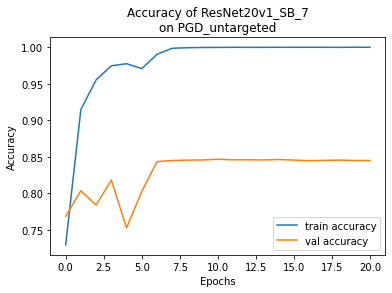

Training specialist for ResNet20v2_SB_0...
best val_accuracy 0.885 (first 0.739)


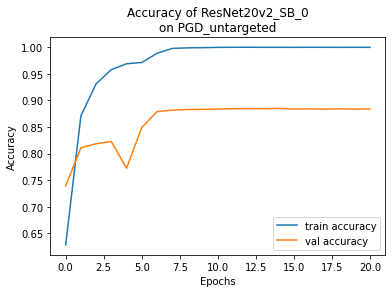

Training specialist for ResNet20v2_SB_1...
best val_accuracy 0.859 (first 0.755)


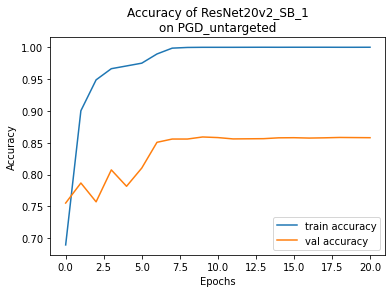

Training specialist for ResNet20v2_SB_2...
best val_accuracy 0.860 (first 0.697)


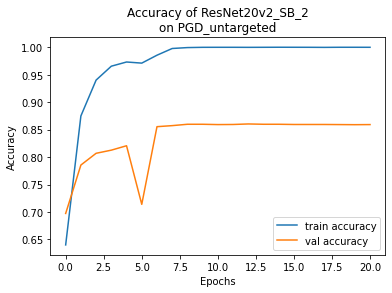

Training specialist for ResNet20v2_SB_3...
best val_accuracy 0.858 (first 0.682)


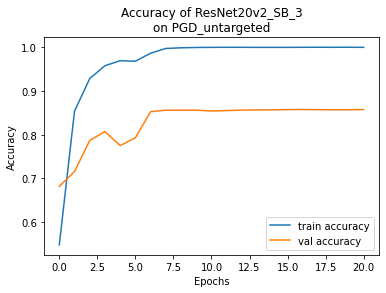

Training specialist for ResNet56v1_SB_0...
best val_accuracy 0.882 (first 0.756)


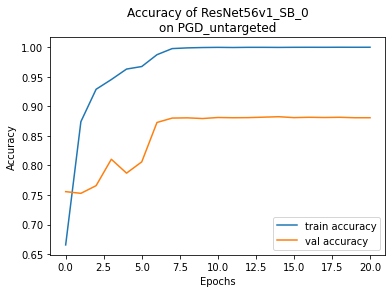

Training specialist for ResNet56v1_SB_1...
best val_accuracy 0.866 (first 0.661)


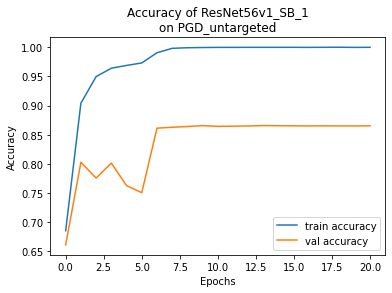

Training specialist for ResNet56v1_SB_2...
best val_accuracy 0.866 (first 0.731)


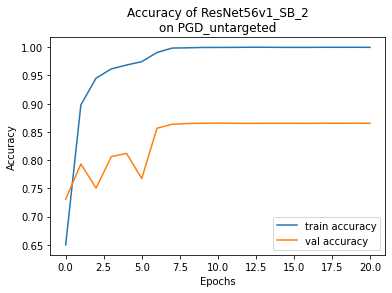

Training specialist for ResNet56v1_SB_3...
best val_accuracy 0.866 (first 0.683)


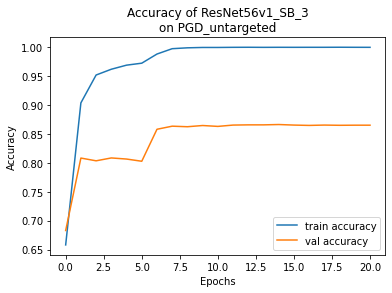

Training specialist for ResNet56v2_SB_0...
best val_accuracy 0.899 (first 0.722)


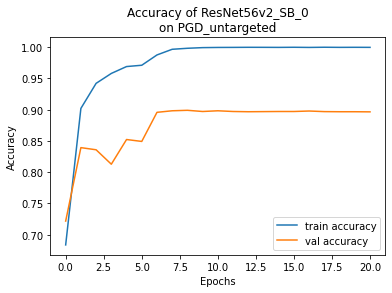

Training specialist for ResNet56v2_SB_1...
best val_accuracy 0.879 (first 0.718)


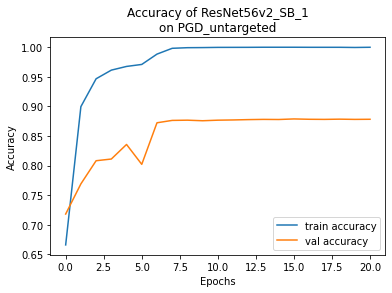

Training specialist for ResNet56v2_SB_2...
best val_accuracy 0.870 (first 0.711)


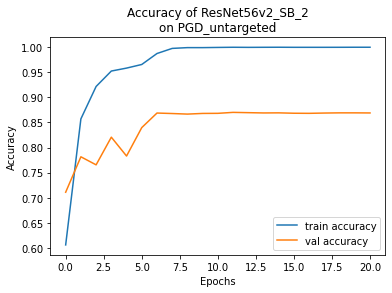

Training specialist for ResNet56v2_SB_3...
best val_accuracy 0.880 (first 0.699)


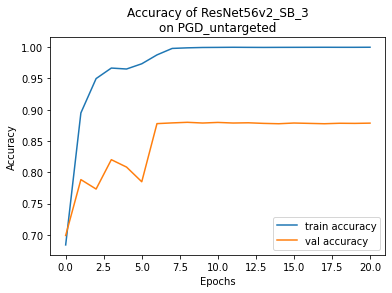

In [121]:
## Specialization happens over PGD untargeted dataset

for key, value in entropy_arrays_SB.items():

        if key[1] == 'train':
            truth = to_categorical(y_train,10)
        elif key[1] == 'val':
            truth = to_categorical(y_val,10)
        
        stats = get_statistics(value)
        alpha = stats['average']
        loc_0 = entropy_arrays_SB[key]<alpha
        loc_1 = entropy_arrays_SB[key]>=alpha

alpha_train = get_statistics(entropy_arrays_SB[('PGD','train')])['average']
loc_1_train = entropy_arrays_SB[('PGD','train')]>=alpha_train
alpha_val = get_statistics(entropy_arrays_SB[('PGD','val')])['average']
loc_1_val = entropy_arrays_SB[('PGD','val')]>=alpha_val
specialize_Committee(Judge_Committee_SB,
                        (adv_dataset[('PGD','train')][loc_1_train],
                        to_categorical(y_train[loc_1_train],10),        
                        adv_dataset[('PGD','val')][loc_1_val],
                        to_categorical(y_val[loc_1_val],10)),
                     './data/specialists/',
                     data_name = 'PGD_untargeted',
                     committee_name = 'SB')

![entropy disagreements (cross entropy) (no "entropy_disagreements.png" at imgaes directory)](./entropy_disagreements.png "entropy disagreements (cross entropy)")

Original train / val / test ---- CWL2 train / val / test ---- PGD train / val / test ---- VGG test

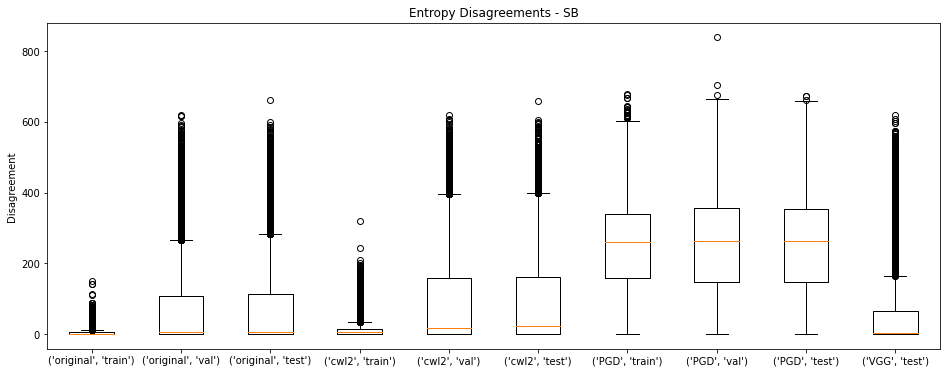

the number of data greater than alpha:
Training set (original, PGD): 3 32649
Validation set (original, PGD): 1937 7149
Union of Training and Validation Sets:
X_train: (32652, 32, 32, 3)
y_train: (32652, 1)
X_val: (9086, 32, 32, 3)
y_val: (9086, 1)
Training specialist for ResNet20v1_SB_0...
best val_accuracy 0.812 (first 0.723)


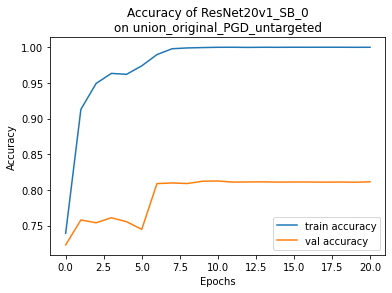

Training specialist for ResNet20v1_SB_1...
best val_accuracy 0.803 (first 0.722)


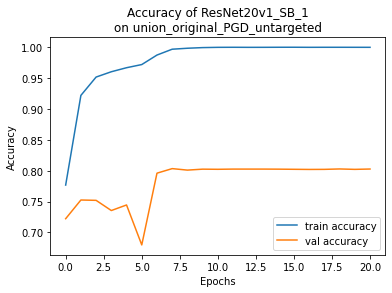

Training specialist for ResNet20v1_SB_2...
best val_accuracy 0.803 (first 0.678)


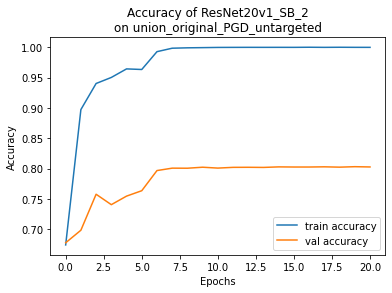

Training specialist for ResNet20v1_SB_3...
best val_accuracy 0.804 (first 0.706)


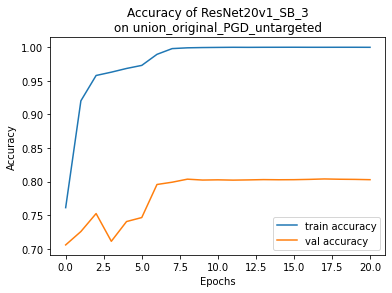

Training specialist for ResNet20v1_SB_4...
best val_accuracy 0.803 (first 0.706)


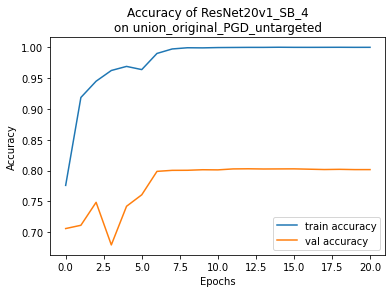

Training specialist for ResNet20v1_SB_5...
best val_accuracy 0.800 (first 0.696)


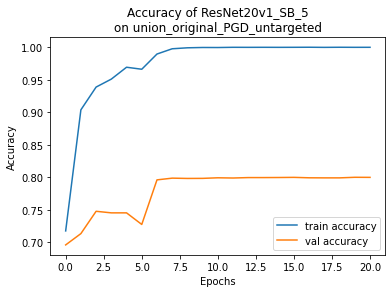

Training specialist for ResNet20v1_SB_6...
best val_accuracy 0.805 (first 0.711)


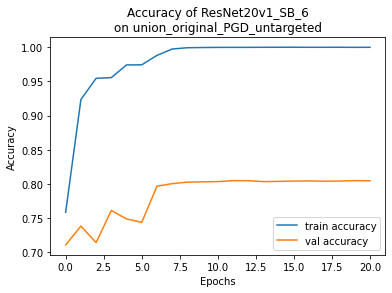

Training specialist for ResNet20v1_SB_7...
best val_accuracy 0.798 (first 0.704)


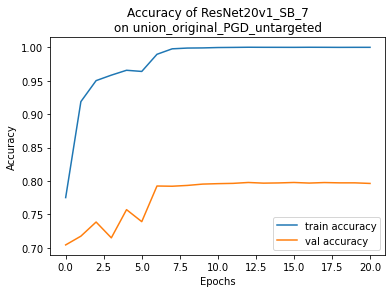

Training specialist for ResNet20v2_SB_0...
best val_accuracy 0.845 (first 0.750)


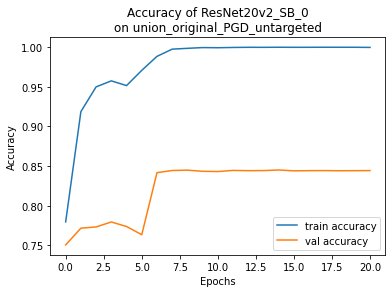

Training specialist for ResNet20v2_SB_1...
best val_accuracy 0.810 (first 0.691)


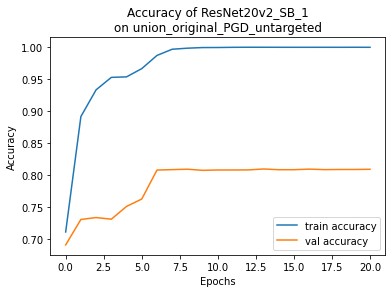

Training specialist for ResNet20v2_SB_2...
best val_accuracy 0.822 (first 0.690)


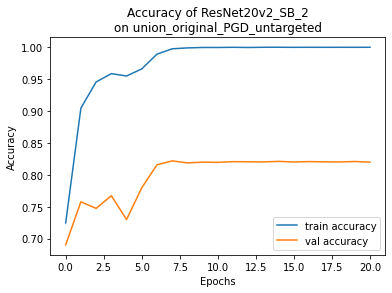

Training specialist for ResNet20v2_SB_3...
best val_accuracy 0.819 (first 0.692)


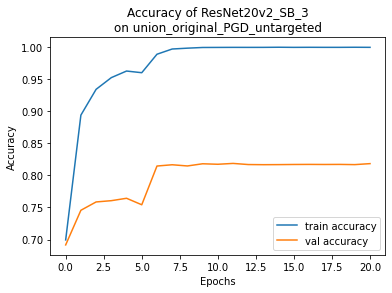

Training specialist for ResNet56v1_SB_0...
best val_accuracy 0.843 (first 0.641)


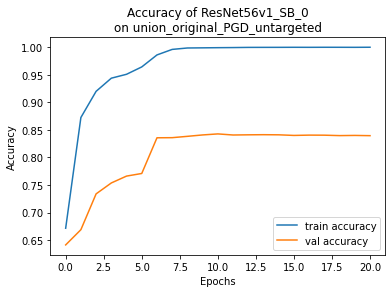

Training specialist for ResNet56v1_SB_1...
best val_accuracy 0.823 (first 0.701)


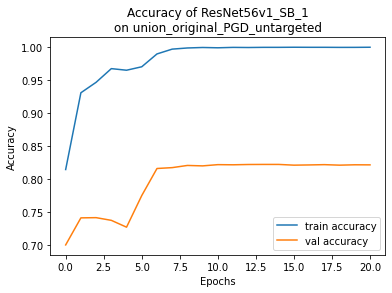

Training specialist for ResNet56v1_SB_2...
best val_accuracy 0.816 (first 0.704)


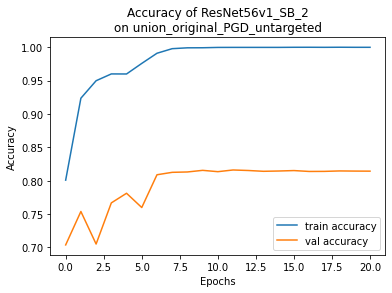

Training specialist for ResNet56v1_SB_3...
best val_accuracy 0.818 (first 0.706)


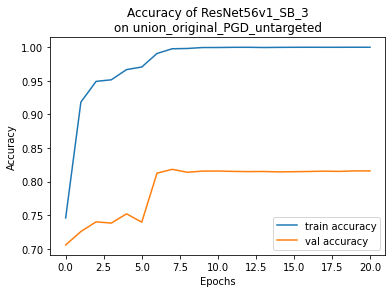

Training specialist for ResNet56v2_SB_0...
best val_accuracy 0.863 (first 0.731)


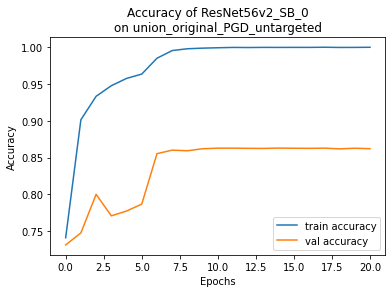

Training specialist for ResNet56v2_SB_1...
best val_accuracy 0.832 (first 0.713)


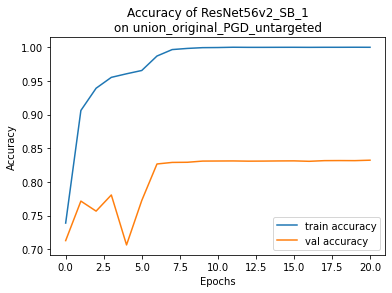

Training specialist for ResNet56v2_SB_2...
best val_accuracy 0.830 (first 0.740)


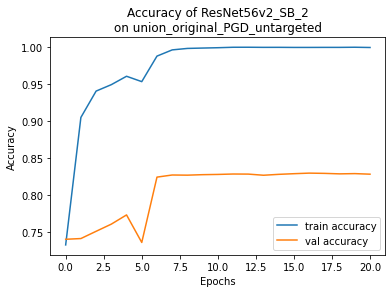

Training specialist for ResNet56v2_SB_3...
best val_accuracy 0.831 (first 0.725)


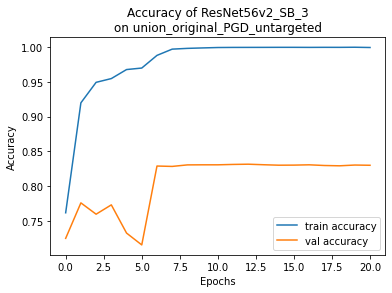

In [10]:
## Specialization happens over the union of original dataset and PGD untargeted sample.

## alpha for original training (or val) ~ 0, and for PGD training (or val) ~ 250. 
## Therefore arithmetic mean of two figures ~ 125.

## First we compose a union of dataset according to the mean of two figures.


## Load entropy arrays from pickle files
import pickle as pkl
with open('./data/entropy_arrays_SB.pkl', 'rb') as f:
    entropy_arrays_SB = pkl.load(f)

plot_disagreements(entropy_arrays_SB, title = "Entropy Disagreements - SB")

# Collect statistics for SB
stats = {}
for key, value in entropy_arrays_SB.items():
    stats[key] = get_statistics(value)

train_alpha = (stats[('original','train')]['average'] + stats[('PGD','train')]['average'])/2
val_alpha = (stats[('original','val')]['average'] + stats[('PGD','val')]['average'])/2

loc_1_original_train = entropy_arrays_SB[('original','train')]>=train_alpha
loc_1_PGD_train = entropy_arrays_SB[('PGD','train')]>=train_alpha
loc_1_original_val = entropy_arrays_SB[('original','val')]>=val_alpha
loc_1_PGD_val = entropy_arrays_SB[('PGD','val')]>=val_alpha

print('the number of data greater than alpha:')
print('Training set (original, PGD):', np.sum(loc_1_original_train), np.sum(loc_1_PGD_train))
print('Validation set (original, PGD):', np.sum(loc_1_original_val), np.sum(loc_1_PGD_val))

union_of_train_x_0 = np.concatenate([x_train[~loc_1_original_train], adv_dataset[('PGD','train')][~loc_1_PGD_train]])
union_of_train_y_0 = np.concatenate([y_train[~loc_1_original_train], y_train[~loc_1_PGD_train]])
union_of_val_x_0 = np.concatenate([x_val[~loc_1_original_val], adv_dataset[('PGD','val')][~loc_1_PGD_val]])
union_of_val_y_0 = np.concatenate([y_val[~loc_1_original_val], y_val[~loc_1_PGD_val]])

union_of_train_x_1 = np.concatenate([x_train[loc_1_original_train], adv_dataset[('PGD','train')][loc_1_PGD_train]])
union_of_train_y_1 = np.concatenate([y_train[loc_1_original_train], y_train[loc_1_PGD_train]])
union_of_val_x_1 = np.concatenate([x_val[loc_1_original_val], adv_dataset[('PGD','val')][loc_1_PGD_val]])
union_of_val_y_1 = np.concatenate([y_val[loc_1_original_val], y_val[loc_1_PGD_val]])

print("Union of Training and Validation Sets:")
print("X_train:", union_of_train_x_1.shape)
print("y_train:", union_of_train_y_1.shape)
print("X_val:", union_of_val_x_1.shape)
print("y_val:", union_of_val_y_1.shape)

specialize_Committee(Judge_Committee_SB,
                        (union_of_train_x_1,
                        to_categorical(union_of_train_y_1,10),        
                        union_of_val_x_1,
                        to_categorical(union_of_val_y_1,10)),
                     './data/specialists/',
                     data_name = 'union_original_PGD_untargeted',
                     committee_name = 'SB')

## accuracies on the union

In [13]:
## Load raw predictions_SB from pickle files
with open('./data/raw_predictions_SB.pkl', 'rb') as f:
    raw_predictions_SB = pkl.load(f)

## samples are union of original and PGD untargeted.
tables = []
for member, model in Judge_Committee_SB:
    row = {"Member": member}
    for key in [('original','train'),('original','val'),('original','test'),('PGD','train'),('PGD','val'),('PGD','test')]:

        if key[1] == 'train':
            truth = y_train.reshape(-1)
            alpha = train_alpha
        elif key[1] == 'val':
            truth = y_val.reshape(-1)
            alpha = val_alpha
        else:
            truth = y_test.reshape(-1)
            alpha = val_alpha
        loc_0 = entropy_arrays_SB[key]<alpha
        loc_1 = entropy_arrays_SB[key]>=alpha
        n = len(loc_0)
    
    
    
        X_0 = raw_predictions_SB[key[0]][key[1]][member][:n][loc_0]
        X_1 = raw_predictions_SB[key[0]][key[1]][member][:n][loc_1]
        acc = np.sum(np.argmax(raw_predictions_SB[key[0]][key[1]][member][:n],axis=-1) == truth[:n]) /len(raw_predictions_SB[key[0]][key[1]][member][:n])
        acc_0 = np.sum((np.argmax(X_0[:n],axis=-1) == truth[:n][loc_0]))/len(X_0[:n])
        acc_1 = np.sum((np.argmax(X_1[:n],axis=-1) == truth[:n][loc_1]))/len(X_1[:n])
    

        row[f"{key}_all"] = np.round(acc, 4)
        row[f"{key}_0"] = np.round(acc_0, 4)
        row[f"{key}_1"] = np.round(acc_1, 4)
    tables.append(row)
table = pd.DataFrame(tables)


In [14]:
table

,Member,"('original', 'train')_all","('original', 'train')_0","('original', 'train')_1","('original', 'val')_all","('original', 'val')_0","('original', 'val')_1","('original', 'test')_all","('original', 'test')_0","('original', 'test')_1","('PGD', 'train')_all","('PGD', 'train')_0","('PGD', 'train')_1","('PGD', 'val')_all","('PGD', 'val')_0","('PGD', 'val')_1","('PGD', 'test')_all","('PGD', 'test')_0","('PGD', 'test')_1"
0,ResNet20v1_SB_0,1.0000,1.0000,1.0000,0.9082,0.9855,0.5865,0.9052,0.9794,0.6075,0.5974,0.6050,0.5957,0.5216,0.5219,0.5215,0.5179,0.5054,0.5228
1,ResNet20v1_SB_1,1.0000,1.0000,1.0000,0.9056,0.9861,0.5705,0.9070,0.9835,0.6000,0.5432,0.6016,0.5300,0.4795,0.5086,0.4679,0.4738,0.5014,0.4631
2,ResNet20v1_SB_2,1.0000,1.0000,1.0000,0.9079,0.9854,0.5854,0.9093,0.9843,0.6085,0.5658,0.6029,0.5575,0.5011,0.5132,0.4963,0.4860,0.5039,0.4790
3,ResNet20v1_SB_3,1.0000,1.0000,1.0000,0.9080,0.9864,0.5818,0.9027,0.9823,0.5835,0.5641,0.6018,0.5555,0.4939,0.5132,0.4862,0.4906,0.5021,0.4861
4,ResNet20v1_SB_4,1.0000,1.0000,1.0000,0.9063,0.9862,0.5736,0.9041,0.9806,0.5970,0.5284,0.5975,0.5129,0.4727,0.5079,0.4587,0.4566,0.4939,0.4421
5,ResNet20v1_SB_5,1.0000,1.0000,1.0000,0.9097,0.9865,0.5901,0.9004,0.9805,0.5789,0.5383,0.6018,0.5240,0.4751,0.5093,0.4615,0.4724,0.4989,0.4621
6,ResNet20v1_SB_6,1.0000,1.0000,1.0000,0.9069,0.9856,0.5792,0.9041,0.9828,0.5885,0.6073,0.6066,0.6074,0.5256,0.5184,0.5285,0.5251,0.5046,0.5331
7,ResNet20v1_SB_7,1.0000,1.0000,1.0000,0.9071,0.9859,0.5792,0.9059,0.9810,0.6045,0.5317,0.5990,0.5166,0.4669,0.5103,0.4496,0.4618,0.4939,0.4493
8,ResNet20v2_SB_0,1.0000,1.0000,1.0000,0.9405,0.9890,0.7388,0.9101,0.9845,0.6115,0.5998,0.6032,0.5991,0.5575,0.5244,0.5707,0.5344,0.5086,0.5444
9,ResNet20v2_SB_1,1.0000,1.0000,1.0000,0.9081,0.9855,0.5860,0.9061,0.9828,0.5985,0.6292,0.6059,0.6345,0.5487,0.5205,0.5599,0.5509,0.5086,0.5674


## Specialists performance

In [33]:
## load specialists


folder = 'specialists/SB/'
pattern = os.path.join(folder, '*.keras')
file_list = sorted(glob.glob(pattern))
loaded_models = {os.path.basename(f): load_model(f) for f in file_list}

## Compose Committee
Specialists_Committee_SB_union = []
Specialists_Committee_SB = []
for file_name, model in loaded_models.items():
    # Extract model name from the file name
    base = file_name.replace('.keras','')
    parts = base.split('_')
    # base = ResNet20v1_SB_4_union_original_PGD_untargeted or ResNet20v1_SB_4_PGD_untargeted
    # parts = [ResNet20v1, SB, #, union, original, PGD, untargeted] or 
    #           [ResNet20v1, SB, #, PGD, untargeted]
    if parts[3] == 'union':
        model_name = parts[0]+f'_SB_{parts[2]}' + '_union_sp'
        Specialists_Committee_SB_union.append((model_name, model))
    else:
        model_name = parts[0] +f'_SB_{parts[2]}'+ '_sp'
        Specialists_Committee_SB.append((model_name, model))

print(f"{len(Specialists_Committee_SB)} specialized models loaded (in each union experts and non-union experts)")


20 specialized models loaded (in each union experts and non-union experts)


In [40]:
tables = []
for member, model in Specialists_Committee_SB: #non union experts
    row = {"Member": member}
    for key in [('original','train'),('original','val'),('original','test'),('PGD','train'),('PGD','val'),('PGD','test')]:
        
        if key[1] == 'train':
            if key[0] == 'original':
                sample = x_train
            else:
                sample = adv_dataset[('PGD','train')]
            truth = y_train.reshape(-1)
#             alpha = train_alpha
        elif key[1] == 'val':
            if key[0] == 'original':
                sample = x_val
            else:
                sample = adv_dataset[('PGD','val')]
            truth = y_val.reshape(-1)
#             alpha = val_alpha
        else:
            if key[0] == 'original':
                sample = x_test
            else:
                sample = adv_dataset[('PGD','test')]
            truth = y_test.reshape(-1)
#             alpha = val_alpha
        alpha = get_statistics(entropy_arrays_SB[key])['average']
        loc_0 = entropy_arrays_SB[key]<alpha
        loc_1 = entropy_arrays_SB[key]>=alpha
        n = len(loc_0)
        print(f'update raw prediction with {member} on {key}')
        raw_predictions_SB[key[0]][key[1]][member] = model.predict(sample,verbose = 0)
        
    
    
        X_0 = raw_predictions_SB[key[0]][key[1]][member][:n][loc_0]
        X_1 = raw_predictions_SB[key[0]][key[1]][member][:n][loc_1]
        acc = np.sum(np.argmax(raw_predictions_SB[key[0]][key[1]][member][:n],axis=-1) == truth[:n]) /len(raw_predictions_SB[key[0]][key[1]][member][:n])
        acc_0 = np.sum((np.argmax(X_0[:n],axis=-1) == truth[:n][loc_0]))/len(X_0[:n])
        acc_1 = np.sum((np.argmax(X_1[:n],axis=-1) == truth[:n][loc_1]))/len(X_1[:n])
    

        row[f"{key}_all"] = np.round(acc, 4)
        row[f"{key}_0"] = np.round(acc_0, 4)
        row[f"{key}_1"] = np.round(acc_1, 4)
    tables.append(row)
table = pd.DataFrame(tables)

update raw prediction with ResNet20v1_SB_0_sp on ('original', 'train')
update raw prediction with ResNet20v1_SB_0_sp on ('original', 'val')
update raw prediction with ResNet20v1_SB_0_sp on ('original', 'test')
update raw prediction with ResNet20v1_SB_0_sp on ('PGD', 'train')
update raw prediction with ResNet20v1_SB_0_sp on ('PGD', 'val')
update raw prediction with ResNet20v1_SB_0_sp on ('PGD', 'test')
update raw prediction with ResNet20v1_SB_1_sp on ('original', 'train')
update raw prediction with ResNet20v1_SB_1_sp on ('original', 'val')
update raw prediction with ResNet20v1_SB_1_sp on ('original', 'test')
update raw prediction with ResNet20v1_SB_1_sp on ('PGD', 'train')
update raw prediction with ResNet20v1_SB_1_sp on ('PGD', 'val')
update raw prediction with ResNet20v1_SB_1_sp on ('PGD', 'test')
update raw prediction with ResNet20v1_SB_2_sp on ('original', 'train')
update raw prediction with ResNet20v1_SB_2_sp on ('original', 'val')
update raw prediction with ResNet20v1_SB_2_sp on (

In [41]:
table

,Member,"('original', 'train')_all","('original', 'train')_0","('original', 'train')_1","('original', 'val')_all","('original', 'val')_0","('original', 'val')_1","('original', 'test')_all","('original', 'test')_0","('original', 'test')_1","('PGD', 'train')_all","('PGD', 'train')_0","('PGD', 'train')_1","('PGD', 'val')_all","('PGD', 'val')_0","('PGD', 'val')_1","('PGD', 'test')_all","('PGD', 'test')_0","('PGD', 'test')_1"
0,ResNet20v1_SB_0_sp,0.9757,0.9945,0.9321,0.8833,0.9824,0.6379,0.8817,0.9814,0.6401,0.9573,0.9096,1.0,0.8444,0.8294,0.8580,0.8398,0.8118,0.8652
1,ResNet20v1_SB_1_sp,0.9724,0.9928,0.9250,0.8757,0.9801,0.6174,0.8758,0.9791,0.6253,0.9520,0.8984,1.0,0.8377,0.8184,0.8552,0.8376,0.8172,0.8561
2,ResNet20v1_SB_2_sp,0.9764,0.9943,0.9348,0.8808,0.9820,0.6303,0.8797,0.9811,0.6339,0.9575,0.9101,1.0,0.8449,0.8262,0.8619,0.8411,0.8210,0.8593
3,ResNet20v1_SB_3_sp,0.9728,0.9935,0.9246,0.8730,0.9778,0.6136,0.8712,0.9787,0.6106,0.9539,0.9024,1.0,0.8380,0.8199,0.8544,0.8368,0.8141,0.8574
4,ResNet20v1_SB_4_sp,0.9736,0.9938,0.9265,0.8744,0.9805,0.6119,0.8763,0.9775,0.6308,0.9491,0.8923,1.0,0.8310,0.8115,0.8487,0.8293,0.8132,0.8439
5,ResNet20v1_SB_5_sp,0.9676,0.9923,0.9102,0.8693,0.9760,0.6053,0.8653,0.9746,0.6003,0.9485,0.8910,1.0,0.8334,0.8128,0.8521,0.8265,0.8044,0.8465
6,ResNet20v1_SB_6_sp,0.9746,0.9937,0.9303,0.8773,0.9810,0.6206,0.8783,0.9819,0.6271,0.9518,0.8979,1.0,0.8350,0.8182,0.8502,0.8342,0.8069,0.8589
7,ResNet20v1_SB_7_sp,0.9765,0.9941,0.9354,0.8796,0.9805,0.6300,0.8791,0.9832,0.6267,0.9540,0.9027,1.0,0.8358,0.8237,0.8468,0.8334,0.8111,0.8536
8,ResNet20v2_SB_0_sp,0.9704,0.9927,0.9183,0.9004,0.9834,0.6949,0.8798,0.9788,0.6397,0.9513,0.8969,1.0,0.8671,0.8474,0.8849,0.8477,0.8267,0.8667
9,ResNet20v2_SB_1_sp,0.9726,0.9930,0.9252,0.8797,0.9834,0.6230,0.8812,0.9816,0.6377,0.9484,0.8908,1.0,0.8340,0.8065,0.8590,0.8392,0.8126,0.8633


In [42]:
## samples are union of original and PGD untargeted.
tables = []
for member, model in Specialists_Committee_SB_union: #union experts
    row = {"Member": member}
    for key in [('original','train'),('original','val'),('original','test'),('PGD','train'),('PGD','val'),('PGD','test')]:
        
        if key[1] == 'train':
            if key[0] == 'original':
                sample = x_train
            else:
                sample = adv_dataset[('PGD','train')]
            truth = y_train.reshape(-1)
            alpha = train_alpha
        elif key[1] == 'val':
            if key[0] == 'original':
                sample = x_val
            else:
                sample = adv_dataset[('PGD','val')]
            truth = y_val.reshape(-1)
            alpha = val_alpha
        else:
            if key[0] == 'original':
                sample = x_test
            else:
                sample = adv_dataset[('PGD','test')]
            truth = y_test.reshape(-1)
            alpha = val_alpha
#         alpha = get_statistics(entropy_arrays_SB[key])['average']
        loc_0 = entropy_arrays_SB[key]<alpha
        loc_1 = entropy_arrays_SB[key]>=alpha
        n = len(loc_0)
        if member not in raw_predictions_SB[key[0]][key[1]]:
            print(f'update raw prediction with {member} on {key}')
            raw_predictions_SB[key[0]][key[1]][member] = model.predict(sample,verbose = 0)
        
    
    
        X_0 = raw_predictions_SB[key[0]][key[1]][member][:n][loc_0]
        X_1 = raw_predictions_SB[key[0]][key[1]][member][:n][loc_1]
        acc = np.sum(np.argmax(raw_predictions_SB[key[0]][key[1]][member][:n],axis=-1) == truth[:n]) /len(raw_predictions_SB[key[0]][key[1]][member][:n])
        acc_0 = np.sum((np.argmax(X_0[:n],axis=-1) == truth[:n][loc_0]))/len(X_0[:n])
        acc_1 = np.sum((np.argmax(X_1[:n],axis=-1) == truth[:n][loc_1]))/len(X_1[:n])
    

        row[f"{key}_all"] = np.round(acc, 4)
        row[f"{key}_0"] = np.round(acc_0, 4)
        row[f"{key}_1"] = np.round(acc_1, 4)
    tables.append(row)
table = pd.DataFrame(tables)

update raw prediction with ResNet20v1_SB_0_union_sp on ('original', 'train')
update raw prediction with ResNet20v1_SB_0_union_sp on ('original', 'val')
update raw prediction with ResNet20v1_SB_0_union_sp on ('original', 'test')
update raw prediction with ResNet20v1_SB_0_union_sp on ('PGD', 'train')
update raw prediction with ResNet20v1_SB_0_union_sp on ('PGD', 'val')
update raw prediction with ResNet20v1_SB_0_union_sp on ('PGD', 'test')
update raw prediction with ResNet20v1_SB_1_union_sp on ('original', 'train')
update raw prediction with ResNet20v1_SB_1_union_sp on ('original', 'val')
update raw prediction with ResNet20v1_SB_1_union_sp on ('original', 'test')
update raw prediction with ResNet20v1_SB_1_union_sp on ('PGD', 'train')
update raw prediction with ResNet20v1_SB_1_union_sp on ('PGD', 'val')
update raw prediction with ResNet20v1_SB_1_union_sp on ('PGD', 'test')
update raw prediction with ResNet20v1_SB_2_union_sp on ('original', 'train')
update raw prediction with ResNet20v1_SB_

update raw prediction with ResNet56v2_SB_2_union_sp on ('PGD', 'val')
update raw prediction with ResNet56v2_SB_2_union_sp on ('PGD', 'test')
update raw prediction with ResNet56v2_SB_3_union_sp on ('original', 'train')
update raw prediction with ResNet56v2_SB_3_union_sp on ('original', 'val')
update raw prediction with ResNet56v2_SB_3_union_sp on ('original', 'test')
update raw prediction with ResNet56v2_SB_3_union_sp on ('PGD', 'train')
update raw prediction with ResNet56v2_SB_3_union_sp on ('PGD', 'val')
update raw prediction with ResNet56v2_SB_3_union_sp on ('PGD', 'test')


In [43]:
table

,Member,"('original', 'train')_all","('original', 'train')_0","('original', 'train')_1","('original', 'val')_all","('original', 'val')_0","('original', 'val')_1","('original', 'test')_all","('original', 'test')_0","('original', 'test')_1","('PGD', 'train')_all","('PGD', 'train')_0","('PGD', 'train')_1","('PGD', 'val')_all","('PGD', 'val')_0","('PGD', 'val')_1","('PGD', 'test')_all","('PGD', 'test')_0","('PGD', 'test')_1"
0,ResNet20v1_SB_0_union_sp,0.9891,0.9891,1.0,0.8891,0.9681,0.5601,0.8835,0.9645,0.5584,0.9822,0.9033,1.0000,0.8605,0.8095,0.8808,0.8551,0.7871,0.8815
1,ResNet20v1_SB_1_union_sp,0.9872,0.9872,1.0,0.8824,0.9656,0.5359,0.8771,0.9625,0.5343,0.9816,0.9001,0.9999,0.8581,0.8137,0.8758,0.8501,0.7882,0.8742
2,ResNet20v1_SB_2_union_sp,0.9866,0.9866,1.0,0.8811,0.9664,0.5261,0.8729,0.9593,0.5263,0.9820,0.9023,1.0000,0.8608,0.8176,0.8780,0.8573,0.8000,0.8796
3,ResNet20v1_SB_3_union_sp,0.9888,0.9888,1.0,0.8844,0.9704,0.5266,0.8816,0.9665,0.5409,0.9824,0.9045,1.0000,0.8596,0.8106,0.8791,0.8557,0.7889,0.8817
4,ResNet20v1_SB_4_union_sp,0.9878,0.9878,1.0,0.8825,0.9660,0.5348,0.8815,0.9597,0.5679,0.9802,0.8924,1.0000,0.8536,0.7983,0.8756,0.8496,0.7811,0.8762
5,ResNet20v1_SB_5_union_sp,0.9865,0.9865,1.0,0.8798,0.9640,0.5292,0.8745,0.9592,0.5348,0.9812,0.8977,1.0000,0.8536,0.8043,0.8733,0.8488,0.7843,0.8739
6,ResNet20v1_SB_6_union_sp,0.9900,0.9900,1.0,0.8827,0.9661,0.5354,0.8816,0.9634,0.5534,0.9821,0.9026,1.0000,0.8561,0.8011,0.8780,0.8523,0.7839,0.8789
7,ResNet20v1_SB_7_union_sp,0.9884,0.9884,1.0,0.8800,0.9649,0.5266,0.8776,0.9604,0.5454,0.9810,0.8970,1.0000,0.8496,0.7952,0.8713,0.8456,0.7836,0.8697
8,ResNet20v2_SB_0_union_sp,0.9880,0.9880,1.0,0.9043,0.9738,0.6149,0.8901,0.9698,0.5704,0.9823,0.9038,1.0000,0.8853,0.8299,0.9074,0.8689,0.8075,0.8928
9,ResNet20v2_SB_1_union_sp,0.9879,0.9879,1.0,0.8866,0.9676,0.5493,0.8845,0.9649,0.5619,0.9811,0.8970,1.0000,0.8595,0.8071,0.8804,0.8572,0.7811,0.8868


In [44]:
## dump raw predictions into pickle files
with open('./data/raw_predictions_SB.pkl', 'wb') as f:
    pkl.dump(raw_predictions_SB, f)